In [1]:
import numpy as np
from matplotlib import pyplot as plt

import sys
np.set_printoptions(threshold=sys.maxsize)

np.random.seed(14)

In [2]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y 

In [4]:
total_bandwidth = 100e6 # [Hz]
tx_power = 1 # [W]

environment_constant = 1e-4
pathloss_constant = 4

ref_distance = 1 # [m]

In [5]:
def random_ue_positions(num_ue, cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    num_ue : int
        The number of UEs.
    '''
    
    ue_positions = np.zeros((num_ue, 2))
    
    for ue in range(num_ue):
        ue_positions[ue] = [np.random.rand() * cov_side, np.random.rand() * cov_side]
        
    return ue_positions

In [6]:
def ap_positions(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel(), y_pos.ravel()))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')

In [7]:
def distance(ue_pos, ap_pos, ref_distance=1):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ap_pos : int, float
        The AP position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''

    dis_matrix = np.zeros((ue_pos.shape[0], ap_pos.shape[0]))
    
    for ue in range(ue_pos.shape[0]):
        for ap in range(ap_pos.shape[0]):
            dis = np.sqrt(((ue_pos[ue])[0] - (ap_pos[ap])[0])**2
                          + ((ue_pos[ue])[1] - (ap_pos[ap])[1])**2)

            if dis >= ref_distance:
                dis_matrix[ue, ap] = dis
            else:
                dis_matrix[ue, ap] = ref_distance

    return dis_matrix

In [8]:
def shadowing(std, num_ue, num_ap):

    return np.random.lognormal(sigma = std, size = (num_ue, num_ap))

In [9]:
def rayleigh(std, num_ue, num_ap, num_ch):

    return np.sqrt((std*np.random.randn(num_ch, num_ue, num_ap))**2 + (std*np.random.randn(num_ch, num_ue, num_ap))**2) 

In [10]:
def random_channel(distance, shadowing, rayleigh):

    channel = shadowing * (environment_constant / (distance ** pathloss_constant)) * rayleigh**2
    
    for row in range(rayleigh.shape[1]):

        channel[np.random.randint(0, rayleigh.shape[0]), row, :] = np.zeros(rayleigh.shape[2])
        
    return channel

In [11]:
def maximum_channel(distance, shadowing, rayleigh):

    channel = shadowing * (environment_constant / (distance ** pathloss_constant)) * rayleigh**2

    for row in range(rayleigh.shape[1]):
    
        max_channel = channel[:, row, :].max()
        index = np.where(channel[:, row, :] == max_channel)[0][0]

        for ch in range(rayleigh.shape[0]):

            if ch != index:
                
                channel[ch, row, :] = np.zeros(rayleigh.shape[2])
        
    return channel

In [12]:
def sinr(power_vector, channel, power_noise):
    
    sinr_matrix = np.zeros(channel.shape)
    sinr_vector = np.zeros(channel.shape[1])

    for ch in range(channel.shape[0]):

        for col in range(channel.shape[2]):
        
            channel_sum = 0
            
            for row in range(channel.shape[1]):

                channel_sum += np.abs(channel[ch, row, col]) * power_vector[row]
            
            for row in range(channel.shape[1]):
    
                interest_channel = power_vector[row] * np.abs(channel[ch, row, col])
    
                sinr_matrix[ch, row, col] = interest_channel / ((channel_sum - interest_channel) + power_noise)

    
    for row in range(channel.shape[1]):

        sinr_vector[row] = sinr_matrix[:, row, :].max()

    return lin2db(sinr_vector)

In [13]:
def capacity(total_bandwidth, sinr):
    
    return (total_bandwidth * np.log2(1 + db2lin(sinr))) / 1e6

In [14]:
def power_noise(total_bandwidth, num_ch):
    
    return (total_bandwidth/num_ch) * 1e-20

In [15]:
num_ue = 13
num_ap = 64
num_ch = 2

cov_side = 1000 # [m]
seeds = 1000

sh_std = 2
mp_std = 1 / np.sqrt(2) 

noise_p = power_noise(total_bandwidth, num_ch)

In [16]:
total_sinr_random = np.zeros((num_ue, seeds))
total_sinr_maximum = np.zeros((num_ue, seeds))


total_capacity_random = np.zeros((num_ue, seeds))
total_capacity_maximum = np.zeros((num_ue, seeds))

for seed in range(seeds):
    
    ue_pos = random_ue_positions(num_ue, cov_side)
    ap_pos = ap_positions(num_ap, cov_side)
    distances = distance(ue_pos, ap_pos)
    
    shadowing_matrix = shadowing(sh_std, num_ue, num_ap)
    rayleigh_matrix = rayleigh(mp_std, num_ue, num_ap, num_ch)
    
    random_matrix = random_channel(distances, shadowing_matrix, rayleigh_matrix)
    maximum_matrix = maximum_channel(distances, shadowing_matrix, rayleigh_matrix)
    
    npc_power = np.ones(num_ue)
    
    total_sinr_random[:, seed] = sinr(npc_power, random_matrix, noise_p)
    total_sinr_maximum[:, seed] = sinr(npc_power, maximum_matrix, noise_p)
    
    total_capacity_random[:, seed] = capacity(total_bandwidth, sinr(npc_power, random_matrix, noise_p))
    total_capacity_maximum[:, seed] = capacity(total_bandwidth, sinr(npc_power, maximum_matrix, noise_p))

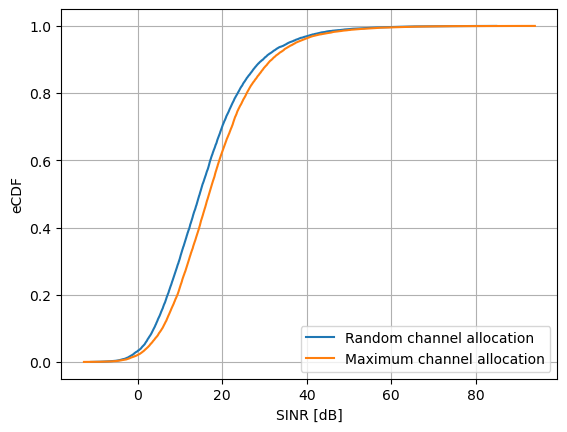

In [18]:
sinr_cdf_random = eCDF(total_sinr_random.flatten())
plt.plot(sinr_cdf_random[0], sinr_cdf_random[1], label='Random channel allocation')

sinr_cdf_maximum = eCDF(total_sinr_maximum.flatten())
plt.plot(sinr_cdf_maximum[0], sinr_cdf_maximum[1], label='Maximum channel allocation')

plt.xlabel('SINR [dB]')
plt.ylabel('eCDF')

plt.legend()
plt.grid()

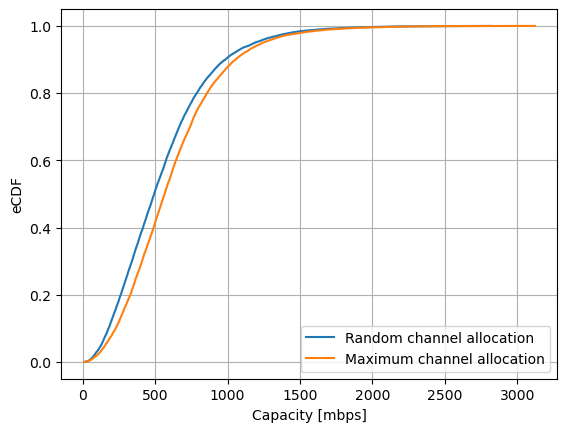

In [19]:
capacity_cdf_random = eCDF(total_capacity_random.flatten())
plt.plot(capacity_cdf_random[0], capacity_cdf_random[1], label='Random channel allocation')

capacity_cdf_maximum = eCDF(total_capacity_maximum.flatten())
plt.plot(capacity_cdf_maximum[0], capacity_cdf_maximum[1], label='Maximum channel allocation')


plt.xlabel('Capacity [mbps]')
plt.ylabel('eCDF')

plt.legend()
plt.grid()